In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.svm import SVR,LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True
from evaluation import forecast_accuracy

import warnings
warnings.filterwarnings('ignore')

In [14]:
df = pd.read_pickle('../dataset/preprocessed/group_imputed.pkl')


print(df.isna().sum())

HotelId
DOA        0
DBA        0
ROH_max    0
ROH_min    0
ROH_med    0
ROH_avg    0
ROH_std    0
DOW        0
LAR_max    0
LAR_min    0
LAR_med    0
LAR_avg    0
LAR_std    0
dtype: int64


In [15]:
df[['DOA', 'DBA','DOW', 'LAR_max', 'LAR_min', 'LAR_med', 'LAR_avg', 'LAR_std', 'ROH_max', 'ROH_min', 'ROH_avg', 'ROH_std', 'ROH_med']].head()

HotelId,DOA,DBA,DOW,LAR_max,LAR_min,LAR_med,LAR_avg,LAR_std,ROH_max,ROH_min,ROH_avg,ROH_std,ROH_med
0,2018-01-01,0.0,0,144.5,38.69,72.9,75.847778,30.871318,194.0,1.0,45.710526,65.541332,19.5
1,2018-01-01,1.0,0,144.5,38.69,72.9,75.847778,30.871318,194.0,1.0,47.368421,64.749892,25.0
2,2018-01-01,10.0,0,144.5,38.69,72.9,75.847778,30.871318,203.0,2.0,47.842105,67.742751,21.0
3,2018-01-01,11.0,0,144.5,38.69,72.9,75.847778,30.871318,203.0,3.0,48.368421,67.552872,22.0
4,2018-01-01,12.0,0,144.5,38.69,72.9,75.847778,30.871318,217.0,3.0,49.842105,70.976099,22.0


In [16]:
df.reset_index()

HotelId,index,DOA,DBA,ROH_max,ROH_min,ROH_med,ROH_avg,ROH_std,DOW,LAR_max,LAR_min,LAR_med,LAR_avg,LAR_std
0,0,2018-01-01,0.0,194.0,1.0,19.5,45.710526,65.541332,0,144.50,38.69,72.900,75.847778,30.871318
1,1,2018-01-01,1.0,194.0,1.0,25.0,47.368421,64.749892,0,144.50,38.69,72.900,75.847778,30.871318
2,2,2018-01-01,10.0,203.0,2.0,21.0,47.842105,67.742751,0,144.50,38.69,72.900,75.847778,30.871318
3,3,2018-01-01,11.0,203.0,3.0,22.0,48.368421,67.552872,0,144.50,38.69,72.900,75.847778,30.871318
4,4,2018-01-01,12.0,217.0,3.0,22.0,49.842105,70.976099,0,144.50,38.69,72.900,75.847778,30.871318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65695,65695,2019-12-31,86.0,750.0,50.0,88.5,167.236842,207.986359,1,346.50,97.28,197.165,206.862333,85.200354
65696,65696,2019-12-31,87.0,771.0,50.0,88.0,169.368421,214.069396,1,355.95,97.28,197.165,210.432333,86.768097
65697,65697,2019-12-31,88.0,775.0,50.0,90.0,170.947368,215.226802,1,355.95,97.28,188.665,208.732333,87.125459
65698,65698,2019-12-31,89.0,770.0,51.0,91.5,171.500000,213.191105,1,355.95,97.28,188.665,201.532333,79.578585


In [5]:
def colToRows(dx,attr):
    # DBA as attributes 
    dx = dx.pivot(index='DOA', columns='DBA', values=attr)
    # Removing sub index from Dataframe
    dx = dx.rename_axis(None, axis = 0)
    cols = {col:attr+str(int(col+1)).zfill(2) for col in dx.columns }
    # renaming columns
    dx = dx.rename(columns=cols)
    return dx.rename(columns={'ROH01':'ROH'}).sort_index(axis=1 ,ascending=False)

def preprocess(dx, cutoff = [0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]):
    dx = dx.rename(columns={'ROH_med':'ROH'})
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    # dx['DBA'] = 89 - dx['DBA']
    dx = dx[dx.DBA.isin(cutoff)]
    # dx['OCC'] = dx['ROH']/dx['Rooms']

    attributes = ['LAR_max', 'LAR_min', 'LAR_med', 'LAR_avg', 'LAR_std', 'ROH_max', 'ROH_min', 'ROH_avg', 'ROH_std', 'ROH']
    result = pd.DataFrame()
    for attribute in attributes:
        temp = colToRows(dx,attribute)
        result = pd.concat([result, temp],axis=1)

    result['DOW'] = result.index.dayofweek
    result['Mon'] = result.index.month
    result['Day'] = result.index.day
    # standardizing prices
    scaler = StandardScaler()
    result[result.columns] = scaler.fit_transform(result[result.columns])

    return result

def train_test_split(dx):
    index = int(len(dx)*0.8)
    train = dx[:index]
    test  = dx[index:]
    return train,test

def plot_train_test(train, test):
    plt.plot(train.index, train['ROH'], label='Train')
    plt.plot(test.index, test['ROH'], label='Test')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

def plot_result(dx):
    plt.plot(dx.index, dx['ROH'], label='test')
    plt.plot(dx.index, dx['PRED'], label='SVR')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

In [6]:
data = preprocess(df)
train,test = train_test_split(data)
train.head(10)

DBA,LAR_max90,LAR_max60,LAR_max30,LAR_max21,LAR_max14,LAR_max07,LAR_max06,LAR_max05,LAR_max04,LAR_max03,...,ROH07,ROH06,ROH05,ROH04,ROH03,ROH02,ROH,DOW,Mon,Day
2018-01-01,-0.579274,-0.674789,-0.614265,-0.612532,-0.626277,-0.627944,-0.624270,-0.622190,-0.618842,-0.611286,...,-0.046818,-0.025862,-0.006252,-0.035586,-0.017722,0.490756,0.025675,-1.495304,-1.602745,-1.673503
2018-01-02,-1.112558,-0.921149,-0.878649,-0.878124,-0.901045,-0.903967,-0.897497,-0.894342,-0.891459,-0.883955,...,-0.348890,-0.328965,-0.310520,-0.296231,-0.279952,-0.260111,0.069775,-0.995729,-1.602745,-1.559818
2018-01-03,-0.712595,-1.290690,-1.407416,-1.409308,-1.450580,-1.456012,-1.443952,-1.438645,-1.436693,-1.429291,...,-0.650962,-0.675369,-0.658254,-0.643757,-0.629593,-0.613460,-0.591729,-0.496154,-1.602745,-1.446134
2018-01-04,0.087332,-1.044329,-1.407416,-1.409308,-1.450580,-1.456012,-1.443952,-1.438645,-1.436693,-1.429291,...,-0.564656,-0.545467,-0.527854,-0.513435,-0.498477,-0.480954,-0.459428,0.003422,-1.602745,-1.332449
2018-01-05,-0.979237,-1.167510,-1.143032,-1.143716,-1.175812,-1.179989,-1.170725,-1.166494,-1.164076,-1.156623,...,-0.866728,-0.848571,-0.832121,-0.817520,-0.804413,-0.790135,-0.768130,0.502997,-1.602745,-1.218764
2018-01-06,-0.979237,-0.921149,-1.143032,-1.143716,-1.175812,-1.179989,-1.170725,-1.166494,-1.164076,-1.156623,...,-1.255106,-1.238275,-1.223322,-1.208488,-1.197759,-1.187653,-1.165032,1.002573,-1.602745,-1.105079
2018-01-07,-1.245879,-1.290690,-1.407416,-1.409308,-1.450580,-1.456012,-1.443952,-1.438645,-1.436693,-1.429291,...,-1.168800,-1.151674,-1.136389,-1.121606,-1.110349,-1.099315,-1.076832,1.502148,-1.602745,-0.991394
2018-01-08,-0.979237,-1.044329,-1.143032,-1.143716,-1.175812,-1.179989,-1.170725,-1.166494,-1.164076,-1.156623,...,-1.341413,-1.324876,-1.310256,-1.295369,-1.285169,-1.320159,-1.297333,-1.495304,-1.602745,-0.877709
2018-01-09,-0.712595,-1.044329,-1.143032,-1.143716,-1.175812,-1.179989,-1.170725,-1.166494,-1.164076,-1.156623,...,-1.427719,-1.411477,-1.397189,-1.382251,-1.372579,-1.364327,-1.341433,-0.995729,-1.602745,-0.764024
2018-01-10,-0.072654,-1.044329,-1.143032,-1.143716,-1.175812,-1.179989,-1.170725,-1.166494,-1.164076,-1.156623,...,-1.341413,-1.324876,-1.310256,-1.295369,-1.285169,-1.275990,-1.253233,-0.496154,-1.602745,-0.650340


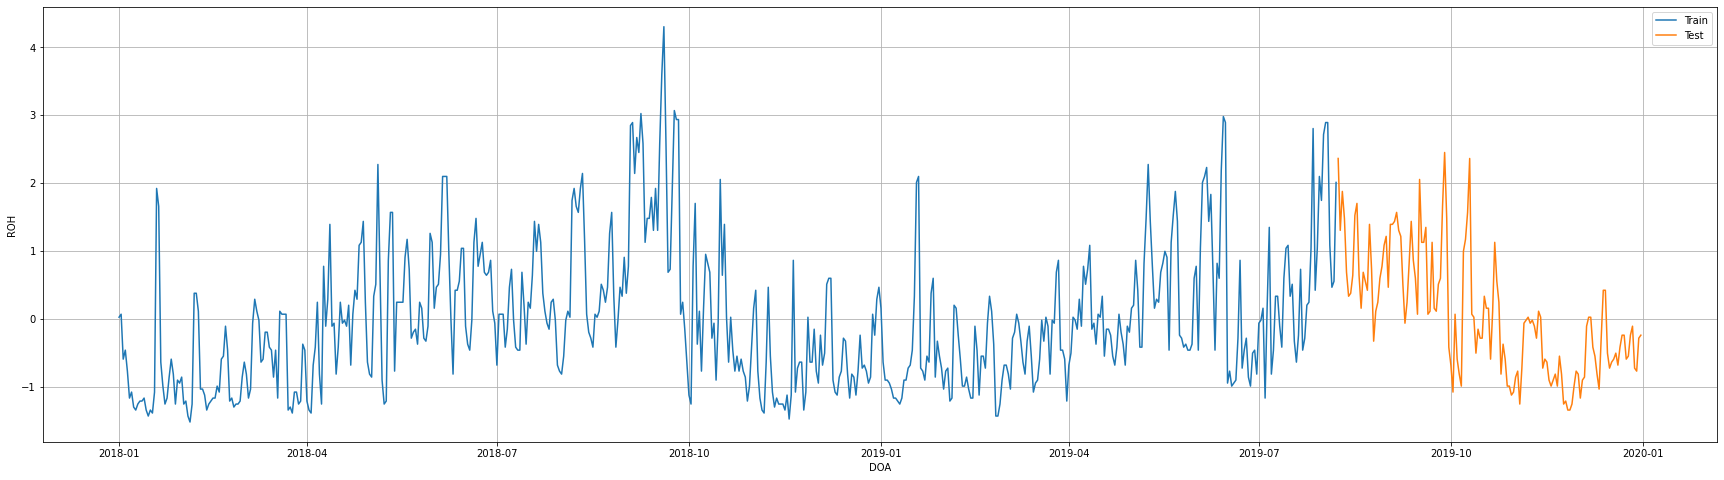

In [7]:
plot_train_test(train,test)

## Model Selection

In [8]:
y = train.pop('ROH')
X = train

In [9]:
param = {'kernel' :['rbf'],'C' : [1,5,10], 'epsilon':[0.01,0.1],'gamma' : ('auto','scale')},

modelsvr = SVR()
grids = GridSearchCV(estimator=modelsvr,param_grid=param,cv=10,scoring='neg_mean_squared_error')
grids.fit(X,y)
grids.best_params_
grids.best_estimator_

SVR(C=1, epsilon=0.01, gamma='auto')

In [10]:
test_predict_cols = [attr for attr in test.columns if attr!='ROH']
test['PRED']  = grids.predict(test[test_predict_cols])

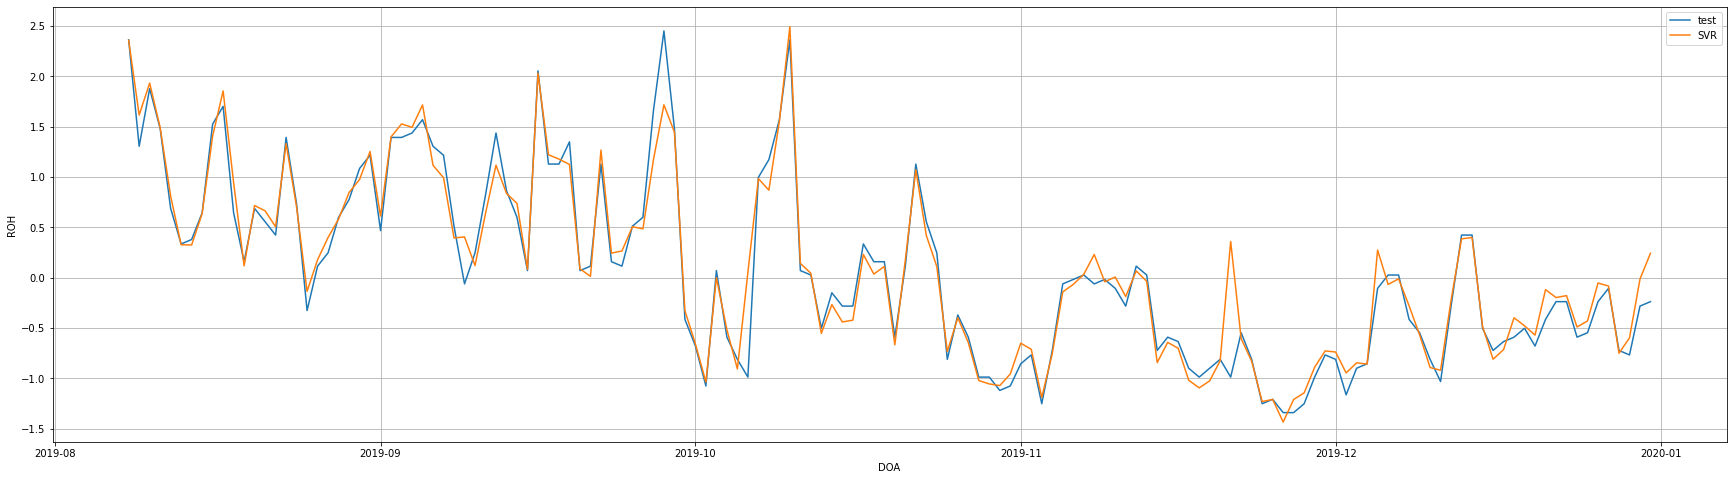

In [11]:
plot_result(test)

In [12]:
forecast_accuracy(test['PRED'],test['ROH'])

0.203	&	0.1839	&	0.1202	&	42.577	&	0.2049	&	0.042	&	0.9474


## Combined results

In [17]:
cuttoffs = [1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
for i in range(0,len(cuttoffs)):
    print('- DBA ',i)
    print([0]+cuttoffs[i:])

    df = pd.read_pickle('../dataset/preprocessed/group_imputed.pkl')
    df = preprocess(df,[0]+cuttoffs[i:])
    train, test = train_test_split(df)
    cols = [col for col in df.columns if col != 'ROH']
    # creating model 
    y = train.pop('ROH')
    X = train
    # grid search best params
    param = {'kernel' :['rbf'],'C' : [1,5,10], 'epsilon':[0.01,0.1],'gamma' : ('auto','scale')},
    modelsvr = SVR()
    grids = GridSearchCV(estimator=modelsvr,param_grid=param,cv=10,scoring='neg_mean_squared_error')
    grids.fit(X,y)
    # grids.best_params_
    # print(grids.best_estimator_)
    # predict with best parameter
    test['PRED'] = grids.predict(test[cols])
    # plot 
    # plot_result(test)    
    # evaluation
    forecast_accuracy(test['PRED'],test['ROH'])

- DBA  0
[0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
0.203	&	0.1839	&	0.1202	&	42.577	&	0.2049	&	0.042	&	0.9474
- DBA  1
[0, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
0.2096	&	0.1954	&	0.1308	&	46.5969	&	0.2123	&	0.0451	&	0.9435
- DBA  2
[0, 3, 4, 5, 6, 13, 20, 29, 59, 89]
0.2153	&	0.1894	&	0.1399	&	49.5555	&	0.2187	&	0.0478	&	0.9401
- DBA  3
[0, 4, 5, 6, 13, 20, 29, 59, 89]
0.2227	&	0.1841	&	0.1486	&	52.4019	&	0.2276	&	0.0518	&	0.9352
- DBA  4
[0, 5, 6, 13, 20, 29, 59, 89]
0.2354	&	0.1816	&	0.1632	&	58.8302	&	0.2432	&	0.0591	&	0.9259
- DBA  5
[0, 6, 13, 20, 29, 59, 89]
0.2668	&	0.2666	&	0.1858	&	88.0239	&	0.2753	&	0.0758	&	0.9051
- DBA  6
[0, 13, 20, 29, 59, 89]
0.3019	&	0.2709	&	0.2373	&	106.0413	&	0.329	&	0.1082	&	0.8644
- DBA  7
[0, 20, 29, 59, 89]
0.3514	&	0.4276	&	0.2773	&	134.9209	&	0.3777	&	0.1427	&	0.8213
- DBA  8
[0, 29, 59, 89]
0.3968	&	0.6633	&	0.3171	&	165.8312	&	0.4284	&	0.1835	&	0.7701
- DBA  9
[0, 59, 89]
0.4721	&	0.3622	&	0.3915	&	212.8339	&	0.5006	&	0.2506	&	0.6862
- DBA  10
[